In [251]:
import numpy as np
from numpy.random import default_rng
import matplotlib.pyplot as plt
from scipy.stats import norm
from function_test import get_A_M_N_R
import pandas as pd

rng = default_rng()


In [252]:
N = 50
T = 200
r = 2

In [253]:
F = rng.standard_normal(size = (T,r))

In [254]:
se2 = np.random.uniform(0.5, 1.5, N)
E = rng.standard_normal(size = (T,N)) * np.sqrt(se2)


In [255]:
L = rng.standard_normal(size  = (N,r))

In [ ]:
X = F@L.T + E

#We standardized the data column-wise, for each cross-sectional asset

X_mean = X.mean(axis = 0)
X_std = X.std(axis=0, ddof = 1)
X_standardized = (X - X_mean) / X_std

In [257]:
#Covariance matrix can be calculated the following way because the mean is null

cov_X = X_standardized@X_standardized.T / (N*T)
eigvals, U = np.linalg.eigh(cov_X)

idx = np.argsort(eigvals)[::-1]
eigvals = eigvals[idx]
U = U[:, idx]

In [258]:
F_hat = np.sqrt(T) * U[:,:r]
Lambda_hat = (X_standardized.T @ F_hat) / T


In [259]:
m = 7

d = np.array([
    [1, 1],
    [1, 0],
    [1, 1],
    [1, 0],
    [1, 1],
    [1, 0],
    [0, 0]
])


s_eps = np.array([0, 0, 0.2, 0.2, 2, 2, 1])

epsilon = np.zeros((T, m))
for j in range(m):
    epsilon[:, j] = rng.normal(0, np.sqrt(s_eps[j]), size=T)
    
G = F @ d.T + epsilon

In [260]:
G_mean = G.mean(axis=0)
G_std = G.std(axis=0, ddof=1)
G_standardized = (G - G_mean) / G_std

In [261]:
t_stats = np.zeros((T, m))
d_hat = np.zeros((r, m))   
G_hat = np.zeros((T, m)) 

for j in range(m):
    G_j = G_standardized[:,j]
    d_hat[:, j] = np.linalg.inv(F_hat.T @ F_hat) @ (F_hat.T @ G_j)
    G_hat[:, j] = F_hat @ d_hat[:, j]
    var_G_hat = np.var(G_hat[:, j], ddof=1)
    t_stats[:, j] = (G_hat[:, j] - G_j) / np.sqrt(var_G_hat)

In [262]:
A = np.zeros(m)
M = np.zeros(m)

alpha = 0.025
F_alpha = norm.ppf(1 - alpha/2)

for j in range(m):
  
    A[j] = np.mean(np.abs(t_stats[:, j]) > F_alpha)  
    M[j] = np.max(np.abs(t_stats[:, j]))

print("A(j) :", A)
print("M(j) :", M)

A(j) : [0.    0.    0.    0.    0.03  0.145 0.665]
M(j) : [ 0.47075926  0.40172138  0.89485387  1.65098097  3.20112743  3.86406609
 15.48104748]


In [263]:
NS = np.zeros(m)
R2 = np.zeros(m)

for j in range(m):

    dj_hat = np.linalg.lstsq(F_hat, G_standardized[:, j], rcond=None)[0]
    G_proj = F_hat @ dj_hat 
    
    error = G_standardized[:, j] - G_proj
    
    var_error = np.var(error, ddof=1)
    var_proj = np.var(G_proj, ddof=1)
    var_total = np.var(G_standardized[:, j], ddof=1)
    
    NS[j] = var_error / var_proj
    R2[j] = var_proj / var_total

print("NS(j):", NS)
print("R²(j):", R2)

NS(j): [2.85691226e-02 2.34518599e-02 1.34607708e-01 2.41374002e-01
 1.10044772e+00 2.11394635e+00 3.33847053e+01]
R²(j): [0.9722244  0.97708553 0.8813619  0.805559   0.47608897 0.32113591
 0.0290827 ]


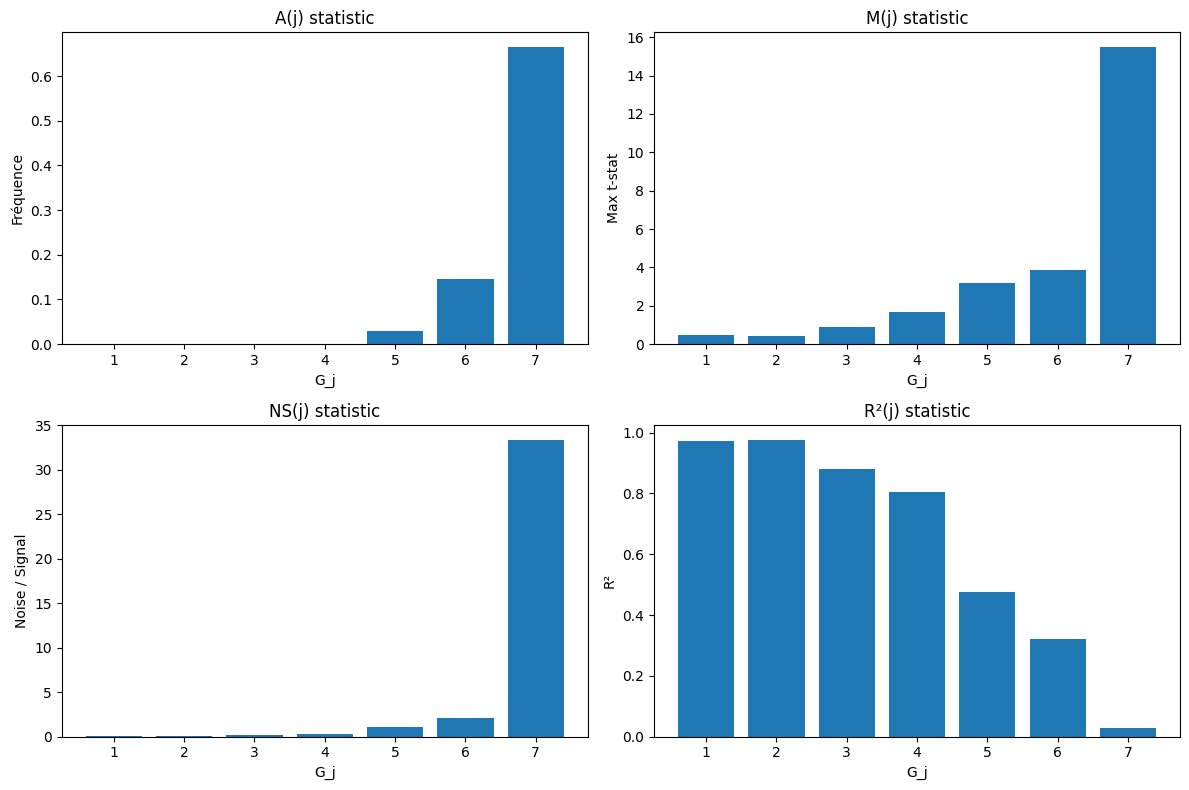

In [264]:
j_indices = np.arange(1, m+1)  

fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# A(j) : frequency of exceeding the critical values
axs[0, 0].bar(j_indices, A)
axs[0, 0].set_title("A(j) statistic")
axs[0, 0].set_xlabel("G_j")
axs[0, 0].set_ylabel("Fréquence")

# M(j) : max t-statistic
axs[0, 1].bar(j_indices, M)
axs[0, 1].set_title("M(j) statistic")
axs[0, 1].set_xlabel("G_j")
axs[0, 1].set_ylabel("Max t-stat")

# NS(j) : Noise-to-signal
axs[1, 0].bar(j_indices, NS)
axs[1, 0].set_title("NS(j) statistic")
axs[1, 0].set_xlabel("G_j")
axs[1, 0].set_ylabel("Noise / Signal")

# R²(j) : Explained variance
axs[1, 1].bar(j_indices, R2)
axs[1, 1].set_title("R²(j) statistic")
axs[1, 1].set_xlabel("G_j")
axs[1, 1].set_ylabel("R²")

plt.tight_layout()
plt.show()